# Marika néni elveszett - megoldás

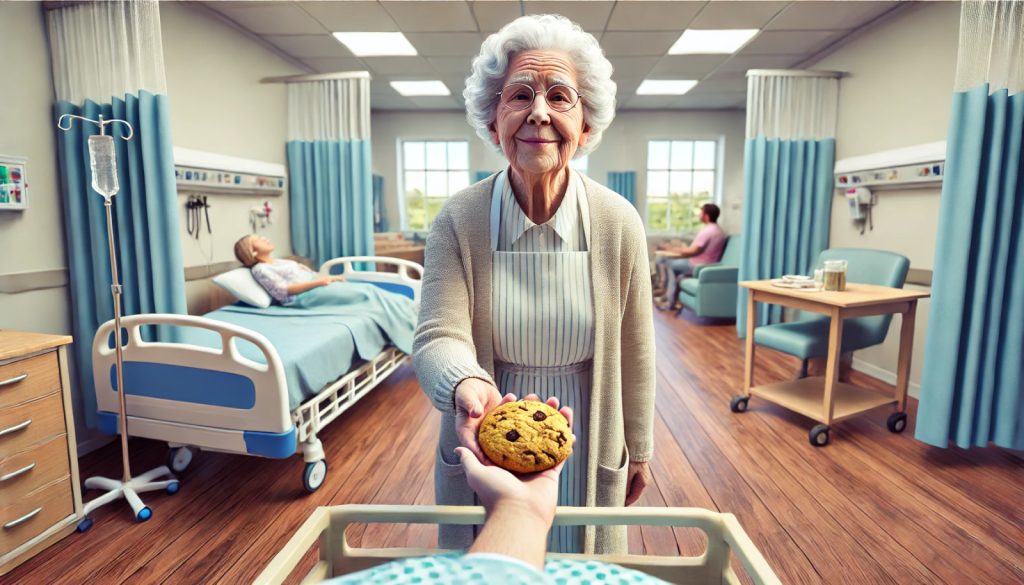


Marika néni csuda kedves, már az első nap körbejárta az egész pulmonológiát, hogy sütit osszon mindenkinek. Hatalmas szíve van! A nagy járkálás közepette viszont elhagyta a karszalagját, amin a páciens azonosítója is szerepelt. Segíts neki kideríteni az azonosítóját, különben nem engedik vissza a kórterembe!

Szerencsére hozzáférésed van:


*   a délelőtt készült mellkasi röntgen felvételekhez (*oitm_xrays*),
*   egy mellkasi röntgen alapján nemet (férfi/nő) azonosító hálóhoz (output: 0:férfi, 1:nő, lehet 0.5 a döntési küszöb) (*x_ray_gender_oitm.keras*)
*   és egy röntgen alapján szerveket szegmentáló hálóhoz. (labelek: 0:háttér, 1:szív, 2:test, 3:tüdő ) (*x_ray_organ_oitm.keras*)
* * Figyelj, mert ez a második háló **invertált röntgent vár**! (versenyen kívül:https://www.sciencedirect.com/science/article/abs/pii/S0735675717301973)

Ha megtalálod **melyik nőnek a legnagyobb a szíve**, kiderítheted Marika néni páciens azonosítóját is!

Válasznak add meg a röntgenfelvétel **fájlnevét, kiterjesztés nélkül!**

In [1]:
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
from keras.models import load_model

Csatolmánoyk letöltése és kitömörítése

In [2]:
! gdown 16U6joasvBULjqI9EOwz34MhsZ5s8fFg-

Downloading...
From (original): https://drive.google.com/uc?id=16U6joasvBULjqI9EOwz34MhsZ5s8fFg-
From (redirected): https://drive.google.com/uc?id=16U6joasvBULjqI9EOwz34MhsZ5s8fFg-&confirm=t&uuid=7a425c0b-3bcb-44c9-9614-e970272b6c3a
To: /content/xray_oitm_data.zip
100% 33.3M/33.3M [00:00<00:00, 44.9MB/s]


In [3]:
!unzip -q xray_oitm_data.zip

Adatok betöltése

In [4]:
BASE_DIR = 'xray_oitm_data/'
xray_dir = BASE_DIR + 'oitm_xrays/'
print("Délelőtti röntgenek száma:" , len(os.listdir(xray_dir)))

Délelőtti röntgenek száma: 93


In [5]:
# populate X_test
X_test = []
test_img_filenames=[]
for img in os.listdir(xray_dir):
    im = cv2.imread(os.path.join(xray_dir, img),0)
    X_test.append(im)
    test_img_filenames.append(img)

# convert to numpy array
X_test = np.array(X_test)
# normalize
X_test = np.expand_dims(X_test, axis=3)/255.
print(X_test.shape)

(93, 256, 256, 1)


Predikciók

In [6]:
model = load_model('xray_oitm_data/x_ray_gender_oitm.keras')
predictions = model.predict(X_test)

model2 = load_model('xray_oitm_data/x_ray_organ_model_oitm.keras')

inverted_images = []
inverted_images_filename = []
for i, pred in enumerate(predictions):
    if pred > 0.5:
        inverted_image = 1 - X_test[i]
        inverted_images.append(inverted_image)
        inverted_images_filename.append(test_img_filenames[i])

inverted_images = np.array(inverted_images)
inverted_predictions = model2.predict(inverted_images)
heart_counts = []
y_pred_argmax = []
for pred in inverted_predictions:
    labels = np.argmax(pred, axis=2)
    y_pred_argmax.append(labels)
    heart_count = np.sum(labels == 1)
    heart_counts.append(heart_count)

index = np.argmax(heart_counts)
print(index)
print(inverted_images_filename[index])


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'Adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 66 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step
15
JPCNN078.png


Pálda plot a szegmentáló hálóhoz

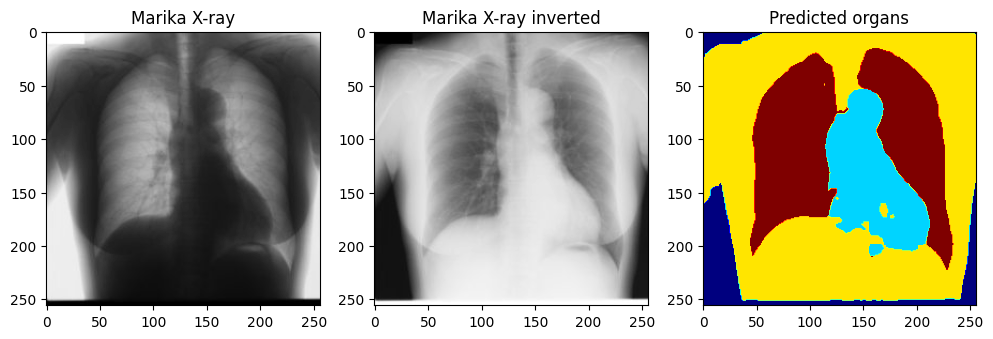

In [7]:
# plot
plt.figure(figsize=(12, 8))
plt.subplot(131)
plt.title('Marika X-ray')
plt.imshow(inverted_images[index].squeeze(axis=2), cmap='gray')
plt.subplot(132)
plt.title('Marika X-ray inverted')
plt.imshow(1-(inverted_images[index].squeeze(axis=2)), cmap='gray')
plt.subplot(133)
plt.title('Predicted organs')
plt.imshow(y_pred_argmax[index], cmap='jet')

plt.show()